<a href="https://colab.research.google.com/github/wadaka0821/nlp-tutorial/blob/main/answers/2_5_logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ロジスティック回帰

作成者：和田  
最終更新日：2023/02/24

In [ ]:
import torch # モデルの定義と実装に使用
import seaborn as sns # グラフ等の可視化に使用
import tqdm # 学習時のプログレスバーの表示
from sklearn.metrics import f1_score, accuracy_score # 評価時のF値，正解率の計算

In [ ]:
seed = 42
# Pytorchのシード値を固定
# 必要に応じてpythonやnumpyなどのシード値も固定する必要があります（再現性を持たせたい場合）
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# 使用可能なデバイスの確認
f'{device=}'

"device='cuda'"

# データの作成
\begin{equation}  
y =
\begin{cases}
    0                 & \text{if $2x_0-3x_1+1 > 0$,} \\
    1       & \text{otherwise}
\end{cases}
\end{equation}
の式に従うような(x, y)のペアを作成します

In [ ]:
slopes = torch.tensor([2, -3], dtype=torch.float) # 傾き
intercept = 1 # 切片

# 学習データの作成
# 0 ~ 1 の一様分布に従うようにxを生成
train_data_num = 1000
train_x = torch.empty(size=(train_data_num, 2))
train_x = torch.Tensor.uniform_(train_x)
train_y = torch.mv(train_x, slopes) + intercept < 0

# テストデータの作成
test_data_num = 100
test_x = torch.empty(size=(test_data_num, 2))
test_x = torch.Tensor.uniform_(test_x)
test_y = torch.mv(test_x, slopes) + intercept < 0

<AxesSubplot:>

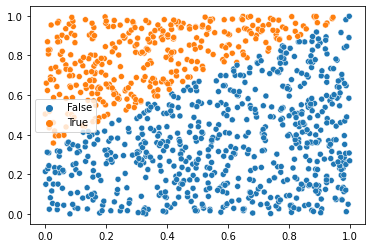

In [ ]:
# 学習データの確認
sns.scatterplot(x=train_x[:,0], y=train_x[:,1], hue=train_y)

# ロジスティック回帰のモデルを作成

In [ ]:
class LogisticRegressionModel(torch.nn.Module):
  '''
  入力が in_dim のロジスティック回帰のモデル
  __init__ で必要なものを一通り定義します（Sigmoid 等も定義しても問題はありませんが，パラメータを持たないものについては定義する必要はありません）
  Pytorch は Define by Run の方式を採用しているので forward メソッドに実際の計算フローを書いていけばモデルの定義ができます
  '''
  def __init__(self, in_dim=2):
    super(LogisticRegressionModel, self).__init__()

    # in_dim 次元の入力から1次元の出力に変換するための全結合層 bias はデフォルトで True
    self.linear = torch.nn.Linear(in_features=in_dim, out_features=1)

  def forward(self, x):
    # logit を計算
    y = self.linear(x)
    # 確率に変換
    y = torch.sigmoid(y)

    return y

# 学習

In [ ]:
MAX_EPOCH = 20 # 学習するエポック数
lr = 1e-2 # 学習率
batch_size = 16 # バッチサイズ

model = LogisticRegressionModel(in_dim=train_x.shape[1]) # モデルのインスタンス化
model.to(device) # モデルのメモリ移動
optimizer = torch.optim.Adam(model.parameters(), lr=lr) # オプティマイザ（学習率の計算やパラメータの更新などを勝手にやってくれます）のインスタンス化

train_y = train_y.float()

# Dataset と DataLoader の作成（Dataset については自作する必要がある場合もあります）
train_datasets = torch.utils.data.TensorDataset(train_x, train_y)
train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size=batch_size)

train_loss_history = list() # 学習時の損失を保存しておくためのリスト

for epoch in range(1, MAX_EPOCH+1):
  for batch_x, batch_y in tqdm.tqdm((train_dataloader)): # tqdm を使うと学習がどのくらい進んでいるか，簡単に確認出来ます
    batch_x.to(device) # 入力のメモリ移動
    batch_y.to(device) # 教師データのメモリ移動
    optimizer.zero_grad(set_to_none=True) # 勾配のリセット（set_to_none=True とすることで速くなる場合があります）
    y_pred = model(batch_x).view(-1) # ベクトルに変換
    loss = torch.mean(- (batch_y * torch.log(y_pred) + (1 - batch_y) * torch.log(1 - y_pred))) # 損失の計算（BCELoss）
    loss.backward() # 勾配の計算

    train_loss_history.append(loss.item()) # 損失の保存
    optimizer.step() # パラメータ更新

100%|██████████| 63/63 [00:00<00:00, 1337.88it/s]


# 損失関数の推移

<AxesSubplot:>

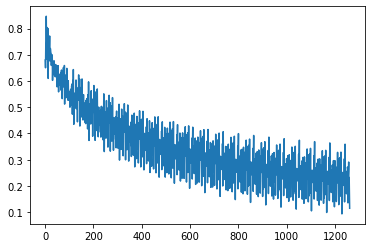

In [ ]:
sns.lineplot(x=[i for i in range(1, len(train_loss_history)+1)], y=train_loss_history)

# 学習データで評価

In [ ]:
train_preds = list()
for batch_x, _ in train_dataloader:
  with torch.no_grad(): # 推論時は忘れずつける（model.eval()でもOK），付け忘れると無駄な計算グラフがメモリに蓄積されていきます
    batch_x.to(device)
    batch_preds = model(batch_x).view(-1) > .5
    train_preds += batch_preds.int().to('cpu').tolist()

In [ ]:
train_acc = accuracy_score(train_y.to('cpu').tolist(), train_preds)
train_f1 = f1_score(train_y.to('cpu').tolist(), train_preds)

print(f'{train_acc=}, {train_f1=}')

train_acc=0.983, train_f1=0.9751098096632502


# テストデータで評価

In [ ]:
test_datasets = torch.utils.data.TensorDataset(test_x, test_y)
test_dataloader = torch.utils.data.DataLoader(test_datasets, batch_size=batch_size)

test_preds = list()
for batch_x, _ in test_dataloader:
  with torch.no_grad():
    batch_x.to(device)
    batch_preds = model(batch_x).view(-1) > .5
    test_preds += batch_preds.int().to('cpu').tolist()

In [ ]:
test_acc = accuracy_score(test_y.to('cpu').tolist(), test_preds)
test_f1 = f1_score(test_y.to('cpu').tolist(), test_preds)

print(f'{test_acc=}, {test_f1=}')

test_acc=0.99, test_f1=0.9824561403508771
